This notebook implements an efficient version of pseudobulk nb-glm based differential expression analysis with DESeq2. Pseudobulk means that all reads from a single batch group (e.g. donor) get pooled into a single observation. 

In general, pseudobulk is statistically preferable to but much slower than Wilcoxon, especially when you need to consider covariates. A more robust but considerably slower alternative to pseudobulk is including donors as random effects. Random effects are preferable for small cell count groups but likely give similar results to pseudobulk estimates for large groups. 

This idea is not at all new. The earliest reference I know for is from Lun et al: 
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7. 


A few implementation notes: 

1) To find markers most upregulated in a cluster, I divide samples into those in and out of the cluster. An alternative is to let each out group remain an independent pseudobulk sample. This is in fact the recommended way from Mike Love: https://support.bioconductor.org/p/118090/. While this is certainly faster than re-estimate size factors for each cluster-specific analysis, I find it gives strange results. Namely, I get more inflated p-values and significant p-values for the wrong canonical marker genes (e.g. CD14 for B cells).  

2) On my laptop, it takes ~20 seconds to run do ~3000 genes from 2700 cells, 3 donors, 2 batches, and 9 cell types. 

# Load some data

In [109]:
devtools::load_all('..')

Loading presto


In [2]:
suppressPackageStartupMessages({
    library(tidyverse)
#     library(presto)
    library(singlecellmethods)
    library(SeuratData)
    library(Seurat)
    library(DESeq2)    
})

fig.size <- function (h, w) 
{
    options(repr.plot.height = h, repr.plot.width = w)
}

Load small dataset for exposition

In [2]:
if (!SeuratData::AvailableData()['pbmc3k.SeuratData', 'Installed']) {
    SeuratData::InstallData("pbmc3k")
}
data("pbmc3k")

Add fake donor and batch columns

In [6]:
pbmc3k@meta.data$donor <- factor(sample(LETTERS[1:3], ncol(pbmc3k), TRUE))
pbmc3k@meta.data$batch <- factor(sample(LETTERS[1:2], ncol(pbmc3k), TRUE))

In [7]:
head(pbmc3k@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,seurat_annotations,donor,batch
,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>
AAACATACAACCAC,pbmc3k,2419,779,Memory CD4 T,B,B
AAACATTGAGCTAC,pbmc3k,4903,1352,B,C,B
AAACATTGATCAGC,pbmc3k,3147,1129,Memory CD4 T,B,A
AAACCGTGCTTCCG,pbmc3k,2639,960,CD14+ Mono,A,A
AAACCGTGTATGCG,pbmc3k,980,521,NK,C,B
AAACGCACTGGTAC,pbmc3k,2163,781,Memory CD4 T,A,A


# Test 

## Collapse to pseudobulk

In [8]:
data_collapsed <- collapse_counts(pbmc3k@assays$RNA@counts, 
                                  pbmc3k@meta.data, 
                                  c('seurat_annotations', 'donor', 'batch'))
head(data_collapsed$meta_data)

,seurat_annotations,donor,batch
,<fct>,<fct>,<fct>
sample_37,Memory CD4 T,B,B
sample_48,B,C,B
sample_10,Memory CD4 T,B,A
sample_2,CD14+ Mono,A,A
sample_51,NK,C,B
sample_1,Memory CD4 T,A,A


## Do DESeq2

In [9]:
res_mat <- pseudobulk_deseq2(~seurat_annotations + donor + batch, 
                             data_collapsed$meta_data,
                             data_collapsed$counts_mat, verbose = TRUE)


Filtered out 10729 genes, analyzing 2985 genes
All vars: seurat_annotations, donor, batch
Contrast var: seurat_annotations
Memory CD4 T
B
CD14+ Mono
NK
CD8 T
Naive CD4 T
FCGR3A+ Mono
DC
Platelet


In [10]:
head(res_mat)

group,feature,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B,CD79B,312.8710,4.596606,0.11896885,38.63706,0.000000e+00,0.000000e+00
B,MS4A1,195.0316,5.820981,0.16796181,34.65658,3.555957e-263,5.307266e-260
B,CD74,2687.7845,2.712676,0.08270321,32.80013,5.863802e-236,5.834483e-233
B,CD79A,379.9878,6.989701,0.22135839,31.57640,7.786960e-219,5.811019e-216
B,CD37,589.0086,2.081310,0.07125680,29.20859,1.508602e-187,9.006352e-185
B,TCL1A,176.3964,6.614657,0.22864700,28.92956,5.073640e-184,2.524136e-181


In [11]:
top_markers_dds(res_mat, lfc_min = 1, padj_max = .05)

rank,B,CD14+ Mono,CD8 T,DC,FCGR3A+ Mono,Memory CD4 T,Naive CD4 T,NK,Platelet
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD79B,S100A9,CCL5,HLA-DPB1,LST1,LTB,RPS27,PRF1,PPBP
2,MS4A1,S100A8,NKG7,FCER1A,COTL1,IL32,RPL9,GNLY,PF4
3,CD74,FTL,GZMH,HLA-DRB1,FTL,LDHB,RPS3A,NKG7,GNG11
4,CD79A,LYZ,GZMK,CLEC10A,AIF1,IL7R,RPS27A,GZMA,NRGN
5,CD37,FTH1,CD8A,CD74,FCER1G,CD3D,RPL31,CTSW,GPX1
6,TCL1A,TYROBP,GZMA,CST3,SAT1,CD3E,RPS25,FGFBP2,MPP1
7,BANK1,S100A6,CTSW,HLA-DRA,FCGR3A,TNFRSF4,LDHB,SPON2,TPM4
8,HLA-DRA,S100A4,CD3D,HLA-DPA1,FTH1,AQP3,RPS29,CST7,NGFRAP1
9,LINC00926,FCN1,CST7,HLA-DRB5,IFITM3,CD2,NPM1,CLIC3,CD9


## Volcano plots

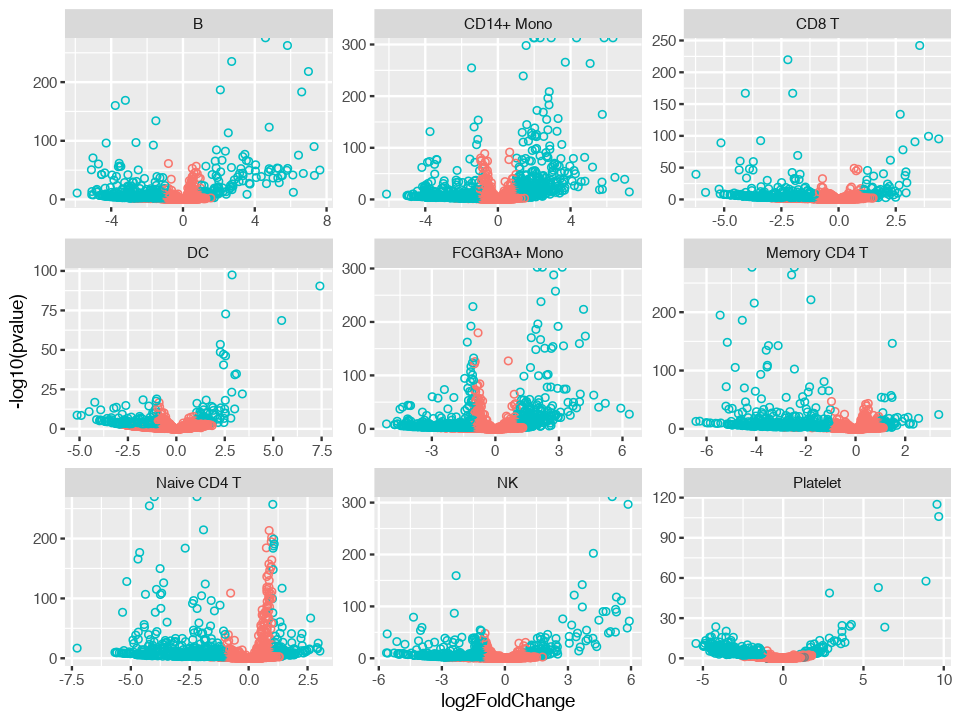

In [12]:
options(repr.plot.height = 6, repr.plot.width = 8)
res_mat %>% 
    ggplot(aes(log2FoldChange, -log10(pvalue), color = padj < .01 & abs(log2FoldChange) > 1)) + 
        geom_point(shape = 21) + 
        facet_wrap(~group, scales = 'free') + 
        guides(color = FALSE) + 
        NULL

# Comparison to Wilcoxon

In this artificial example, donor and batch are fictitious, so DESeq2's GLM $\beta$ estimates should not be that different from the Wilcoxon estimates. Here, we'll compare $\beta$s to auROC, which is essentially equivalent to the Wilxocon statistic. 

In [13]:
## Wilcoxon on CP10K normalized counts 
exprs_norm <- singlecellmethods::normalizeData(pbmc3k@assays$RNA@counts, scaling_factor = 1e4, method = 'log')
dge_wilxocon <- wilcoxauc(exprs_norm, factor(pbmc3k@meta.data$seurat_annotations))


Removing NA values from labels


In [14]:
head(dge_wilxocon)

feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AL627309.1,Naive CD4 T,0.002385006,-0.0041459259,674621.0,0.4986566,0.2969381,0.5033193,0.1434720,0.4121587
AP006222.2,Naive CD4 T,0.000000000,-0.0025103485,675393.0,0.4992272,0.2993548,0.5033193,0.0000000,0.1545595
RP11-206L10.2,Naive CD4 T,0.002616515,0.0001829296,676017.0,0.4996884,0.7459480,0.8712226,0.1434720,0.2060793
RP11-206L10.9,Naive CD4 T,0.000000000,-0.0018526156,675393.0,0.4992272,0.2993548,0.5033193,0.0000000,0.1545595
LINC00115,Naive CD4 T,0.007142957,-0.0051776178,674127.5,0.4982918,0.3475021,0.5567626,0.4304161,0.7727975
NOC2L,Naive CD4 T,0.155593344,-0.0060562808,668592.0,0.4942001,0.3741228,0.5813188,8.6083214,9.9948480


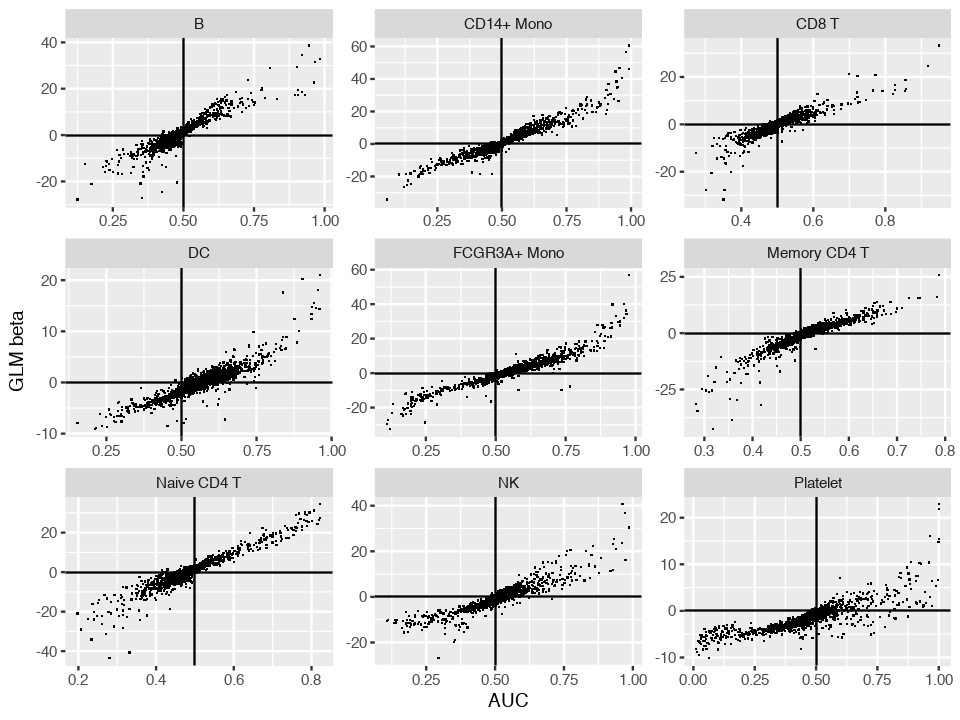

In [15]:
options(repr.plot.height = 6, repr.plot.width = 8)
dplyr::inner_join(dge_wilxocon, res_mat, by = c('feature', 'group')) %>% 
    ggplot(aes(auc, stat)) + 
        geom_point(shape = '.') + 
        facet_wrap(~group, scales = 'free') + 
        geom_vline(xintercept = .5) + 
        geom_hline(yintercept = 0) + 
        labs(x = 'AUC', y = 'GLM beta') + 
        NULL

Most of the results agree, more or less. Interestingly, the Wilcoxon labels almost all genes as upregulated in DCs and CD16+ Monocytes and downregulated in Platelets. What's going on here? It turns out that DCs and CD16+ Monos are mRNA rich cells while platelets are mRNA poor cells overall. DESeq2 is able to account for this effect better than CP10K normalization. 


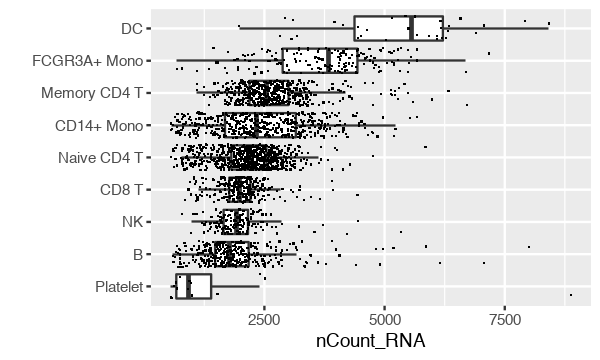

In [16]:
options(repr.plot.height = 3, repr.plot.width = 5)
pbmc3k@meta.data %>% 
    subset(!is.na(seurat_annotations)) %>% 
    ggplot(aes(reorder(seurat_annotations, nCount_RNA), nCount_RNA)) + 
        geom_boxplot(outlier.shape = NA) + 
        geom_jitter(shape = '.', height = 0) + 
        coord_flip() + 
        labs(x = '') + 
        NULL

# Pairwise tests

Instead of 1-vs-all, let's do pairwise test and then summarize statistics conservatively. 

In [17]:
data_collapsed <- collapse_counts(pbmc3k@assays$RNA@counts, 
                                  pbmc3k@meta.data, 
                                  c('seurat_annotations', 'donor', 'batch'))
head(data_collapsed$meta_data)

,seurat_annotations,donor,batch
,<fct>,<fct>,<fct>
sample_37,Memory CD4 T,B,B
sample_48,B,C,B
sample_10,Memory CD4 T,B,A
sample_2,CD14+ Mono,A,A
sample_51,NK,C,B
sample_1,Memory CD4 T,A,A


BUG: when testing all vs all pairwise, crashes

In [18]:
# table(data_collapsed$meta_data$seurat_annotations)

In [19]:
res_pair <- pseudobulk_deseq2(~seurat_annotations + donor + batch, 
                             data_collapsed$meta_data,
                             data_collapsed$counts_mat, verbose = TRUE, mode = 'pairwise')#, vals_test = c('B', 'NK'))


Filtered out 10729 genes, analyzing 2985 genes
All vars: seurat_annotations, donor, batch
Contrast var: seurat_annotations
Memory CD4 T vs B
Memory CD4 T vs CD14+ Mono
Memory CD4 T vs NK
Memory CD4 T vs CD8 T
Memory CD4 T vs Naive CD4 T
Memory CD4 T vs FCGR3A+ Mono
Memory CD4 T vs DC
Memory CD4 T vs Platelet
B vs Memory CD4 T
B vs CD14+ Mono
B vs NK
B vs CD8 T
B vs Naive CD4 T
B vs FCGR3A+ Mono
B vs DC
B vs Platelet
CD14+ Mono vs Memory CD4 T
CD14+ Mono vs B
CD14+ Mono vs NK
CD14+ Mono vs CD8 T
CD14+ Mono vs Naive CD4 T
CD14+ Mono vs FCGR3A+ Mono
CD14+ Mono vs DC
CD14+ Mono vs Platelet
NK vs Memory CD4 T
NK vs B
NK vs CD14+ Mono
NK vs CD8 T
NK vs Naive CD4 T
NK vs FCGR3A+ Mono
NK vs DC
NK vs Platelet
CD8 T vs Memory CD4 T
CD8 T vs B
CD8 T vs CD14+ Mono
CD8 T vs NK
CD8 T vs Naive CD4 T
CD8 T vs FCGR3A+ Mono
CD8 T vs DC
CD8 T vs Platelet
Naive CD4 T vs Memory CD4 T
Naive CD4 T vs B
Naive CD4 T vs CD14+ Mono
Naive CD4 T vs NK
Naive CD4 T vs CD8 T
Naive CD4 T vs FCGR3A+ Mono
Naive CD4 T vs

In [20]:
res_min <- summarize_dge_pairs(res_pair, 'min')
# res_max <- summarize_dge_pairs(res_pair, 'max')

In [ ]:
## Compare to other modes

In [ ]:
dge <- Reduce(rbind, list(
    dplyr::mutate(dge_pairs_min, mode = 'Pairs_min'), 
    dplyr::mutate(dge_pairs_max, mode = 'Pairs_max'), 
    dplyr::mutate(dge_1va_col, mode = 'Onevall_collapse'), 
    dplyr::mutate(dge_1va_no, mode = 'Onevall_no')
    )) 

In [ ]:
plt_df <- dge %>% 
    dplyr::select(feature, log2FoldChange, mode) %>% 
    spread(mode, log2FoldChange)

plt_df <- plt_df[(rowSums(is.na(plt_df)) == 0), ]

In [ ]:
library(ggforce)
fig.size(6, 8)
plt_df %>% 
    ggplot(aes(x = .panel_x, y = .panel_y)) + 
        geom_point(shape = '.') + 
        geom_autodensity(alpha = 0.3, position = 'identity') + 
#         geom_autodensity(position = 'identity') + 
        facet_matrix(
            vars(Pairs_min, Pairs_max, Onevall_collapse, Onevall_no), 
            layer.diag = 2
        ) + 
        geom_vline(aes(xintercept = 0), linetype = 2) + 
        geom_hline(aes(yintercept = 0), linetype = 2) + 
        geom_abline(aes(slope = 1, intercept = 0)) + 
        NULL

In [ ]:
dge_pairs_min %>% 
    subset(stat > 0) %>% 
    dplyr::arrange(-stat) %>% 
    head()

In [ ]:
dge_pairs_max %>% 
    subset(stat > 0) %>% 
    dplyr::arrange(-stat) %>% 
    head()

# Test within clusters 

In [124]:
if (!SeuratData::AvailableData()['ifnb.SeuratData', 'Installed']) {
    SeuratData::InstallData("ifnb")
}
data("ifnb")

## randomly assign donors
ifnb@meta.data$donor <- factor(sample(LETTERS[1:3], ncol(ifnb), TRUE))

In [125]:
head(ifnb@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations,donor
,<chr>,<dbl>,<int>,<chr>,<fct>,<fct>
AAACATACATTTCC.1,IMMUNE_CTRL,3017,877,CTRL,CD14 Mono,B
AAACATACCAGAAA.1,IMMUNE_CTRL,2481,713,CTRL,CD14 Mono,C
AAACATACCTCGCT.1,IMMUNE_CTRL,3420,850,CTRL,CD14 Mono,A
AAACATACCTGGTA.1,IMMUNE_CTRL,3156,1109,CTRL,pDC,B
AAACATACGATGAA.1,IMMUNE_CTRL,1868,634,CTRL,CD4 Memory T,A
AAACATACGGCATT.1,IMMUNE_CTRL,1581,557,CTRL,CD14 Mono,A


In [143]:
data_collapsed <- collapse_counts(ifnb@assays$RNA@counts, 
                                  ifnb@meta.data, 
                                  c('seurat_annotations', 'stim', 'donor'), 
                                     keep_n = TRUE)
head(data_collapsed$meta_data)

,seurat_annotations,stim,donor,N
,<fct>,<chr>,<fct>,<int>
sample_26,CD14 Mono,CTRL,B,728
sample_52,CD14 Mono,CTRL,C,773
sample_0,CD14 Mono,CTRL,A,714
sample_37,pDC,CTRL,B,12
sample_2,CD4 Memory T,CTRL,A,279
sample_32,T activated,CTRL,B,110


In [148]:
data.table(data_collapsed$meta_data)[, sum(N), by = .(stim, seurat_annotations)] %>% 
    tidyr::spread(seurat_annotations, V1)

stim,CD14 Mono,CD4 Naive T,CD4 Memory T,CD16 Mono,B,CD8 T,T activated,NK,DC,B Activated,Mk,pDC,Eryth
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CTRL,2215,978,859,507,407,352,300,298,258,185,115,51,23
STIM,2147,1526,903,537,571,462,333,321,214,203,121,81,32


In [167]:
res_mat <- pseudobulk_deseq2(~seurat_annotations + stim, 
                             data_collapsed$meta_data,
                             data_collapsed$counts_mat, 
                             verbose = TRUE, 
                             vals_test = c('pDC', 'B'),
                             mode = 'within')


Filtered out 7530 genes, analyzing 6523 genes
All vars: seurat_annotations, stim
Contrast var: seurat_annotations
pDC
B


Warning message:
“Column `group`/`seurat_annotations` joining character vector and factor, coercing into character vector”

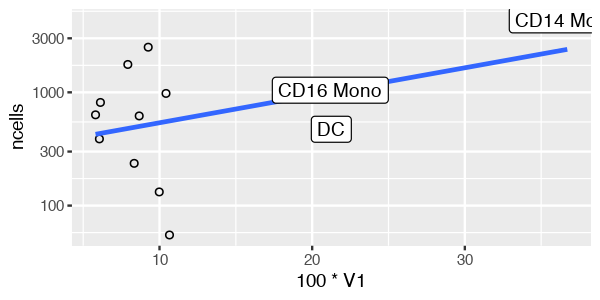

In [166]:
fig.size(2.5, 5)
data.table(res_mat)[, sum(padj < .01, na.rm = TRUE) / .N, by = group][order(-V1)] %>% 
    dplyr::inner_join(
        data.table(data_collapsed$meta_data)[, .(ncells = sum(N)), by = seurat_annotations],
        by = c('group' = 'seurat_annotations')
    ) %>% 
    ggplot(aes(100 * V1, ncells)) + 
        geom_point(shape = 21) + 
        scale_y_log10() + 
        geom_smooth(method = 'lm', se = FALSE) + 
        geom_label(aes(label = group), data = . %>% subset(V1 > .2)) + 
        NULL

In [162]:
devtools::document('..')

Updating presto documentation


Writing NAMESPACE


Loading presto
Loading required package: SingleCellExperiment


Writing NAMESPACE
